# EDA AND PREPROCESSING
## Data Loading

In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.dataset import random_split
from torchsummaryX import summary

print('pytorch version : ',torch.__version__)
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)
print('cuda index:', torch.cuda.current_device())
print('gpu 개수:', torch.cuda.device_count())
print('graphic name:', torch.cuda.get_device_name())


pytorch version :  1.9.0
학습을 진행하는 기기: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA GeForce RTX 3080 Ti


In [2]:
path = r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data'

file_list = os.listdir(path)[2:]
assert len(file_list) == 10
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [3]:
#Normal[label 0] → Fault-free operating condition
#Unbalance[label 1] → Unbalance between centers of mass and axis
#Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
#Belt-Looseness High[label 3] → High Looseness of V-belt
#Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

In [4]:
print(
    train_1st_Normal.shape,
    train_1st_Bearing.shape,
    train_1st_Looseness.shape,
    train_1st_Unbalance.shape,
    train_1st_high.shape,
    train_2nd_Bearing.shape,
    train_2nd_Looseness.shape,
    train_2nd_Unbalance.shape,
    train_3rd_Normal.shape,
    train_3rd_Unbalance.shape
)

(6421296, 2) (18979200, 2) (4384196, 2) (15657840, 2) (11779756, 2) (41020378, 2) (32365862, 2) (30082032, 2) (52907684, 2) (23616452, 2)


## Original Data distribution

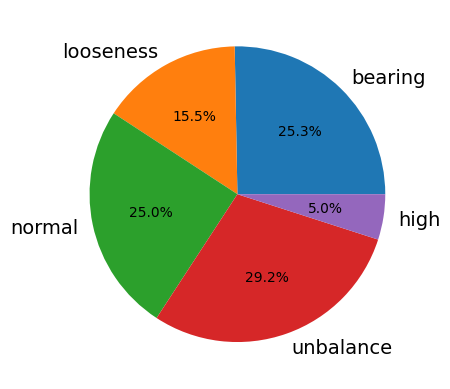

In [5]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('black') 
    items.set_fontsize('14')

plt.show()

## Define Dataset

In [80]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self):
        assert len(self.x) == len(self.y)
        return len(self.x)
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

    def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):  # windows sliding augmentation
        # Normal[label 0] → Fault-free operating condition
        # Unbalance[label 1] → Unbalance between centers of mass and axis
        # Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
        # Belt-Looseness High[label 3] → High Looseness of V-belt
        # Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out
        
        Number_of_samples = int(df.shape[0] / window) - 30
        data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel)) # Defines input shape 
        for i in tqdm(range(Number_of_samples)):
            data_array[i]= df.iloc[window*i : window*i + time_series_length, : ]

        label_array = np.full_like(np.zeros((Number_of_samples)), label)
        data_tensor = torch.as_tensor(data_array).float().permute(0, 2, 1)
        label_tensor = torch.as_tensor(label_array).int()
        dataset = MyDataset(data_tensor, label_tensor)
        return dataset

    def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
        
        Number_of_samples = int(df.shape[0] / window)
        data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel))
        for i in range(Number_of_samples):
            data_array[i]= df.iloc[window*i : window*i + time_series_length, : ]

        label_array = np.full_like(np.zeros(Number_of_samples), label)
        data_tensor = torch.as_tensor(data_array).float().permute(0, 2, 1)
        label_tensor = torch.as_tensor(label_array).int()
        test_dataset = MyDataset(data_tensor, label_tensor)
        return test_dataset
        

In [81]:
sub = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\sample_submission_classification - 복사본.csv')
final = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\final.csv').iloc[:,1:]
test_dataset = MyDataset.TEST_Dataset_Constructor(final)

## Dataset Construction/Augmentation and Solving Class Imbalance Problem

In [74]:
Bearing1st_ds = MyDataset.Dataset_Constructor(train_1st_Bearing, label = 4)
Looseness1st_ds = MyDataset.Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = MyDataset.Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = MyDataset.Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = MyDataset.Dataset_Constructor(train_1st_high, label = 3, window = 30)
Bearing2nd_ds = MyDataset.Dataset_Constructor(train_2nd_Bearing, label = 4)
Looseness2nd_ds = MyDataset.Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = MyDataset.Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = MyDataset.Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = MyDataset.Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184473/184473 [00:05<00:00, 33827.69it/s]


463447 468686 408273 541754 392628


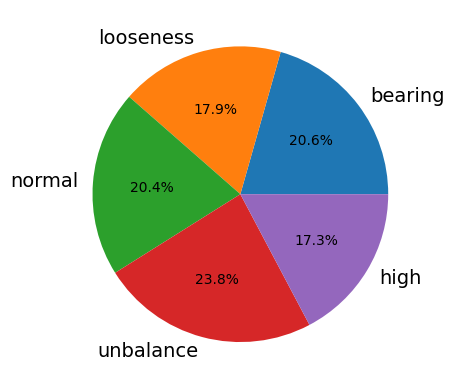

In [9]:
bearing = len(Bearing1st_ds) + len(Bearing2nd_ds)
looseness = len(Looseness1st_ds) + len(Looseness2nd_ds)
normal = len(Normal1st_ds) + len(Normal3rd_ds)
unbalance = len(Unbalance1st_ds) + len(Unbalance2nd_ds) + len(Unbalance3rd_ds)
high = len(High1st_ds)

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')
for items in texts:
    items.set_color('black') 
    items.set_fontsize('14')
print(normal, bearing, looseness, unbalance, high)

plt.show()

In [83]:
from torch.utils.data import ConcatDataset

Dataset = ConcatDataset([
    Normal1st_ds,
    Bearing1st_ds,
    Unbalance1st_ds,
    Looseness1st_ds,
    High1st_ds,
    Bearing2nd_ds,
    Unbalance2nd_ds,
    Looseness2nd_ds,
    Normal3rd_ds,
    Unbalance3rd_ds
])
Dataset.__len__()

2274788

In [84]:
BATCH_SIZE = 512

val_length = int(0.2*Dataset.__len__())
train_length = int(Dataset.__len__() - val_length)

train_dataset, val_dataset = random_split(Dataset, [train_length, val_length])
train_sampler, val_sampler, test_sampler = RandomSampler(train_dataset), RandomSampler(val_dataset), RandomSampler(test_dataset)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, sampler=test_sampler)

In [85]:
for data in train_loader:
  print(data[0].shape)  # data
  print(data[1].shape)  # label
  break
for data in val_loader:
  print(data[0].shape)
  print(data[1].shape)
  break
for data in test_loader:
  print(data[0].shape)
  print(data[1].shape)
  break

torch.Size([512, 2, 128])
torch.Size([512])
torch.Size([512, 2, 128])
torch.Size([512])
torch.Size([512, 2, 128])
torch.Size([512])


# VISUALIZATION

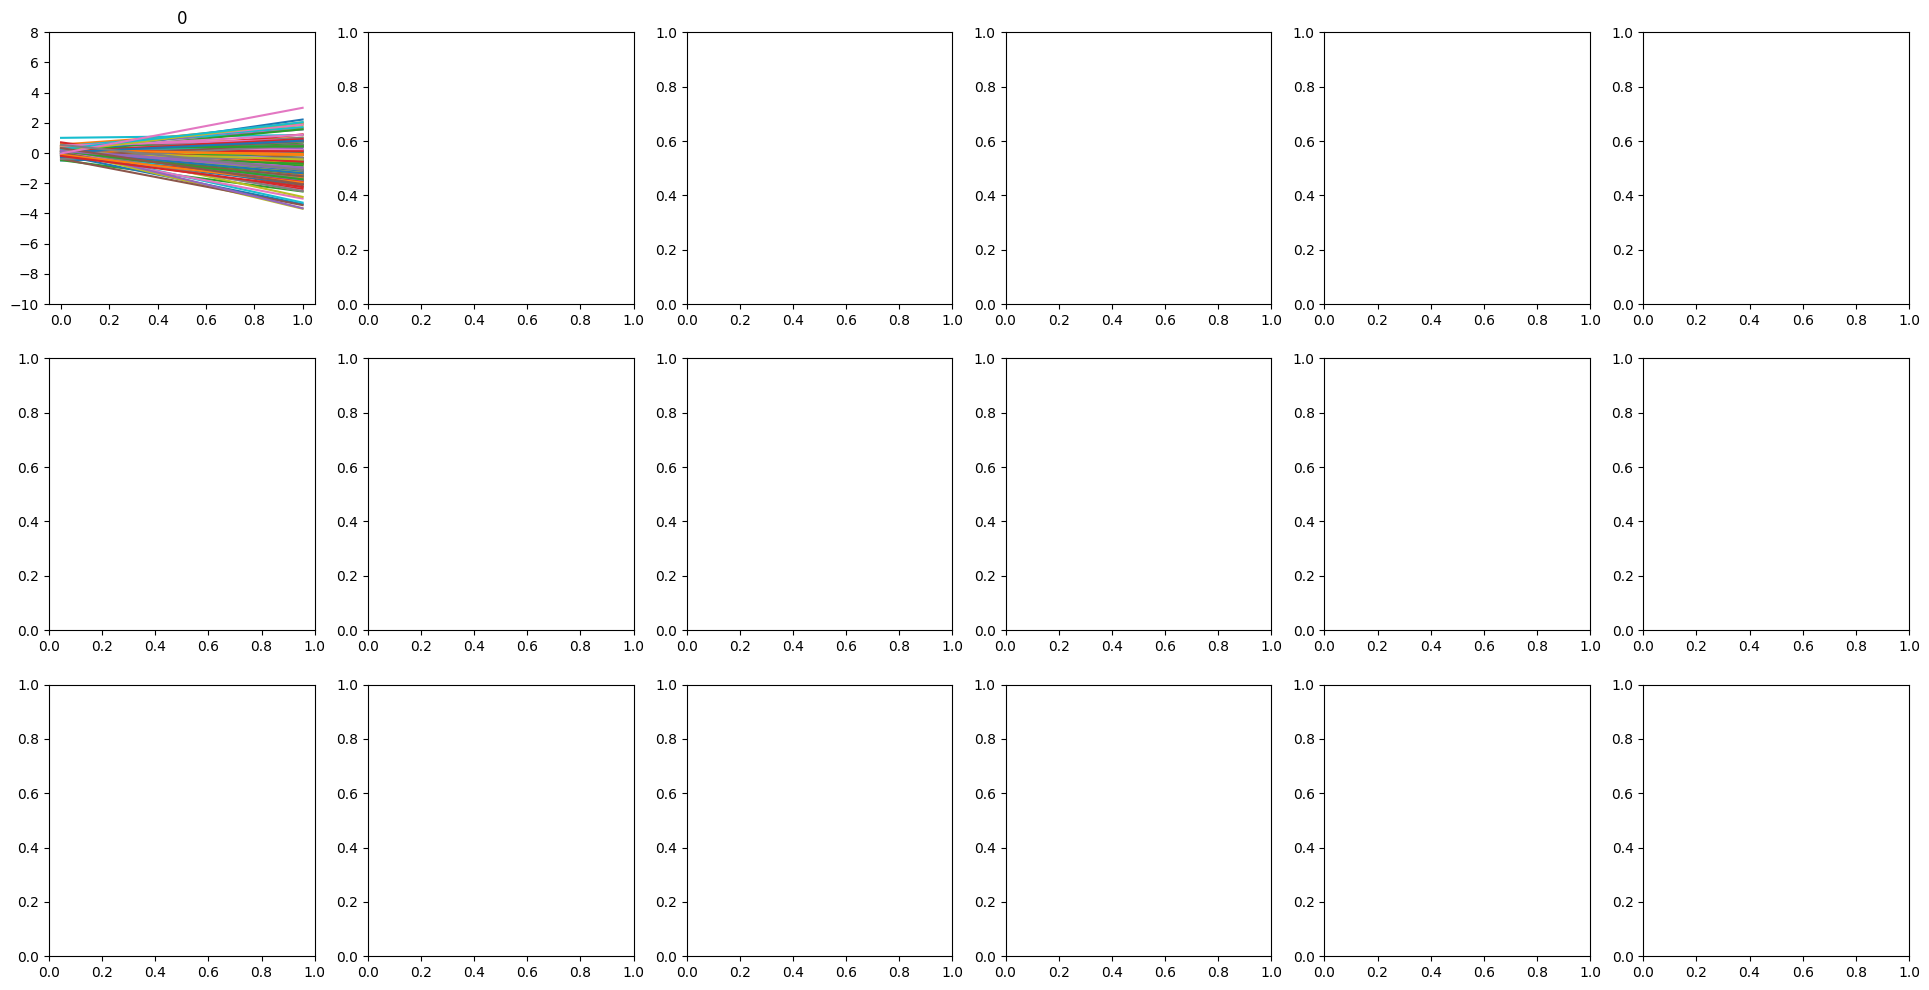

In [36]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))

for i, (audio, label) in enumerate(train_loader):
  if i >=18 : #batch 18개만 뽑아서, show 하기
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio[0].numpy()) # 각 배치의 첫번째 데이터를 시각화
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label[0].numpy())#.decode('utf-8')
  ax.set_title(label)
  plt.show()

# Fast Fourier Transform and Continuous Wavelet Transform

## https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

## https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [37]:
import pywt
from scipy import fftpack
# fft : 신호 데이터셋에서 시간 정보를 없애므로 정보 손실 발생하는 단점이 존재함.
# wavelet transform : wavelet을 filter로서 사용, 

In [38]:
Sample_Batch = list(next(iter(train_loader))) # get one batch
Sample_data, Sample_label = Sample_Batch[0], Sample_Batch[1] #data, label 분리
Sample_data[255].shape #One data

torch.Size([2, 128])

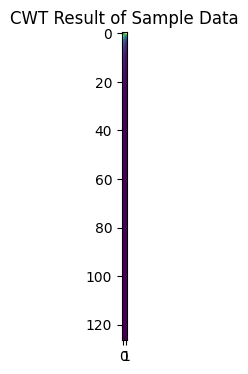

In [39]:
coef, freqs = pywt.cwt(Sample_data[255].numpy() ,np.arange(1, 128), 'gaus1' , axis = 0)
plt.figure().set_size_inches(4, 4)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

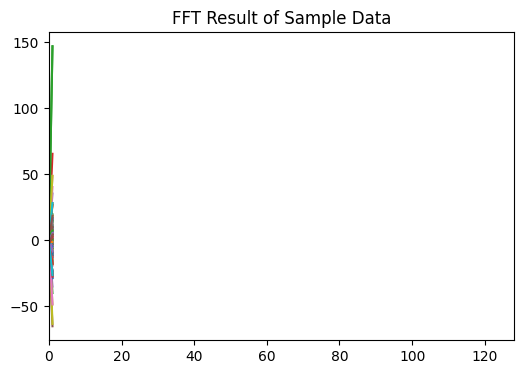

In [40]:
imag = fftpack.fft(Sample_data[255].numpy()).imag
real = fftpack.fft(Sample_data[255].numpy()).real
plt.figure().set_size_inches(6, 4)
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

# CUSTOM MODELING

In [41]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    dirpath = './base.model',
    filename = 'model-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    monitor='val_accuracy',
    verbose=True,
    mode='max',
    save_weights_only=False,
    every_n_epochs = 1
)
earlystop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.003,  # minimum value to determine 'improved'
    patience=3,
    verbose=True,
    mode='max'
)

callbacks = [checkpoint, earlystop]

## functional CLSTM

In [42]:
NUM_CLASSES = 5
class CUSTOM_MODEL(nn.Module):
    def __init__(self):
        super(CUSTOM_MODEL, self).__init__()
        
        self.conv_set1 = self.conv_layer_set(2, 32)
        self.conv_set2 = self.conv_layer_set(32, 64)
        self.conv_set3 = self.conv_layer_set(64, 128)
        self.LSTM = nn.LSTM(128, 64, bidirectional = True)
        self.flatten = nn.Flatten()
        self.fc_set1 = self.fc_layer_set(16384, 1024)
        self.fc_set2 = self.fc_layer_set(1024, 256)
        self.fc_set3 = self.fc_layer_set(256, NUM_CLASSES)      
        
    def conv_layer_set(self, c_in, c_out):
        conv_set = nn.Sequential(
            nn.Conv1d(c_in, c_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(c_out),
            nn.SiLU()
        )
        return conv_set

    def fc_layer_set(self, n_in, n_out):
        fc_set = nn.Sequential(
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.SiLU(),
            nn.Dropout(p=0.2)
        )
        return fc_set

    def forward(self, x):
        x = self.conv_set1(x)
        x = self.conv_set2(x)
        x = self.conv_set3(x)
        x, _= self.LSTM(x)
        x = self.flatten(x)
        x = self.fc_set1(x)
        x = self.fc_set2(x)
        x = self.fc_set3(x)
        return x  # crossentropyloss의 경우 softmax를 마지막에 붙이지 않음.

model = CUSTOM_MODEL()
summary(model, torch.zeros(BATCH_SIZE, 2, 128))

                            Kernel Shape     Output Shape     Params  \
Layer                                                                  
0_conv_set1.Conv1d_0          [2, 32, 3]   [512, 32, 128]      224.0   
1_conv_set1.BatchNorm1d_1           [32]   [512, 32, 128]       64.0   
2_conv_set1.SiLU_2                     -   [512, 32, 128]          -   
3_conv_set2.Conv1d_0         [32, 64, 3]   [512, 64, 128]     6.208k   
4_conv_set2.BatchNorm1d_1           [64]   [512, 64, 128]      128.0   
5_conv_set2.SiLU_2                     -   [512, 64, 128]          -   
6_conv_set3.Conv1d_0        [64, 128, 3]  [512, 128, 128]    24.704k   
7_conv_set3.BatchNorm1d_1          [128]  [512, 128, 128]      256.0   
8_conv_set3.SiLU_2                     -  [512, 128, 128]          -   
9_LSTM                                 -  [512, 128, 128]    99.328k   
10_flatten                             -     [512, 16384]          -   
11_fc_set1.Linear_0        [16384, 1024]      [512, 1024]  16.77

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv_set1.Conv1d_0,"[2, 32, 3]","[512, 32, 128]",224.0,24576.0
1_conv_set1.BatchNorm1d_1,[32],"[512, 32, 128]",64.0,32.0
2_conv_set1.SiLU_2,-,"[512, 32, 128]",NaN,NaN
3_conv_set2.Conv1d_0,"[32, 64, 3]","[512, 64, 128]",6208.0,786432.0
4_conv_set2.BatchNorm1d_1,[64],"[512, 64, 128]",128.0,64.0
5_conv_set2.SiLU_2,-,"[512, 64, 128]",NaN,NaN
6_conv_set3.Conv1d_0,"[64, 128, 3]","[512, 128, 128]",24704.0,3145728.0
7_conv_set3.BatchNorm1d_1,[128],"[512, 128, 128]",256.0,128.0
8_conv_set3.SiLU_2,-,"[512, 128, 128]",NaN,NaN


## Deploy tensorboard in Pytorch

In [43]:
from torch.utils.tensorboard import SummaryWriter
num_epochs = 10
writer = SummaryWriter()
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                        lr=0.01, betas=(0.9, 0.999), eps=1e-08, 
                        weight_decay = 0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=3, 
                threshold=0.0005,
                cooldown=2, 
                verbose=True
            )

In [44]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))

1819831
454957


# Train
## Define Training Step

In [45]:
import gc
gc.collect()
torch.cuda.empty_cache() # CUDA 메모리 정리 

In [52]:
def train(loader, model, epoch):
    print('Epoch {} start'.format(epoch))
    running_loss = 0.0
    num_correct = 0
    num_samples = len(loader.dataset)
    batch_cnt = int(num_samples/BATCH_SIZE)
    model.to(device)
    model.train()
    for batch_idx, (X, y) in enumerate(tqdm(loader)):
        X = X.to(device).float()
        y = y.to(device).long()
    
        optimizer.zero_grad()
        # 순전파 
        y_pred = model(X)
        loss = criterion(y_pred, y)
        num_correct += y_pred.argmax(-1).eq(y).float().sum()
        # 역전파 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss/batch_cnt
        train_acc = (num_correct.cpu().item() / num_samples) * 100

        if batch_idx % batch_cnt == batch_cnt-1:
            writer.add_scalar('train_accuracy', train_acc, epoch)
            writer.add_scalar('train_loss', train_loss, epoch)
            print("EPOCH {} train_loss : {:.5f}, train_accuracy : {:.2f}%".format(epoch, train_loss, train_acc))
            running_loss = 0.0
            
def validate(loader, model, epoch):
    #print("working on val set...")
    num_correct = 0
    num_samples = len(loader.dataset)
    val_loss = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device).float()  # move to device, e.g. GPU
            y = y.to(device).long()
            y_pred = model(X)
            val_loss.append(criterion(y_pred, y).item())
            num_correct += y_pred.argmax(-1).eq(y).float().sum()
        
        val_acc = (num_correct.cpu().item() / num_samples) * 100
        val_loss = torch.mean(torch.tensor(val_loss)).item()
        scheduler.step(val_loss) # val_loss가 개선되지 않으면 lr scheduler 실행
        writer.add_scalar('val_accuracy', val_acc, epoch)
        writer.add_scalar('val_loss', val_loss, epoch)

        #print('Got {} / {} correct'.format(num_correct, num_samples))
        print("EPOCH {} val_loss : {:.5f}, val_accuracy : {:.2f}%".format(epoch, val_loss, val_acc))


## Train

In [53]:
for epoch in range(num_epochs):
    train(train_loader, model, epoch)
    validate(val_loader, model, epoch)
    

epoch 0 start


100%|██████████| 3555/3555 [03:42<00:00, 15.96it/s]


EPOCH 0 train_loss : 0.28364, train_accuracy : 93.48%
Checking accuracy on val set


100%|██████████| 889/889 [00:19<00:00, 45.15it/s]


Got 454495.0 / 454957 correct
EPOCH 0 val_loss : 0.00469, val_accuracy : 99.90%
epoch 1 start


100%|██████████| 3555/3555 [03:36<00:00, 16.39it/s]


EPOCH 1 train_loss : 0.28234, train_accuracy : 93.53%
Checking accuracy on val set


100%|██████████| 889/889 [00:19<00:00, 45.03it/s]


Got 454786.0 / 454957 correct
EPOCH 1 val_loss : 0.00205, val_accuracy : 99.96%
epoch 2 start


100%|██████████| 3555/3555 [03:49<00:00, 15.51it/s]


EPOCH 2 train_loss : 0.28182, train_accuracy : 93.58%
Checking accuracy on val set


100%|██████████| 889/889 [00:22<00:00, 40.07it/s]


Got 454832.0 / 454957 correct
EPOCH 2 val_loss : 0.00141, val_accuracy : 99.97%
epoch 3 start


100%|██████████| 3555/3555 [03:44<00:00, 15.85it/s]


EPOCH 3 train_loss : 0.28148, train_accuracy : 93.54%
Checking accuracy on val set


100%|██████████| 889/889 [00:19<00:00, 44.93it/s]


Got 454795.0 / 454957 correct
EPOCH 3 val_loss : 0.00200, val_accuracy : 99.96%
epoch 4 start


100%|██████████| 3555/3555 [03:39<00:00, 16.20it/s]


EPOCH 4 train_loss : 0.28112, train_accuracy : 93.57%
Checking accuracy on val set


100%|██████████| 889/889 [00:21<00:00, 40.47it/s]


Got 454799.0 / 454957 correct
EPOCH 4 val_loss : 0.00163, val_accuracy : 99.97%
epoch 5 start


100%|██████████| 3555/3555 [03:44<00:00, 15.82it/s]


EPOCH 5 train_loss : 0.28050, train_accuracy : 93.61%
Checking accuracy on val set


100%|██████████| 889/889 [00:21<00:00, 40.62it/s]


Got 454838.0 / 454957 correct
EPOCH 5 val_loss : 0.00122, val_accuracy : 99.97%
epoch 6 start


100%|██████████| 3555/3555 [03:49<00:00, 15.51it/s]


EPOCH 6 train_loss : 0.28091, train_accuracy : 93.56%
Checking accuracy on val set


100%|██████████| 889/889 [00:20<00:00, 43.99it/s]


Got 454592.0 / 454957 correct
EPOCH 6 val_loss : 0.00341, val_accuracy : 99.92%
epoch 7 start


100%|██████████| 3555/3555 [03:49<00:00, 15.47it/s]


EPOCH 7 train_loss : 0.28123, train_accuracy : 93.56%
Checking accuracy on val set


100%|██████████| 889/889 [00:22<00:00, 40.29it/s]


Got 454819.0 / 454957 correct
EPOCH 7 val_loss : 0.00136, val_accuracy : 99.97%
epoch 8 start


100%|██████████| 3555/3555 [03:51<00:00, 15.38it/s]


EPOCH 8 train_loss : 0.28097, train_accuracy : 93.59%
Checking accuracy on val set


100%|██████████| 889/889 [00:22<00:00, 39.31it/s]


Got 454884.0 / 454957 correct
EPOCH 8 val_loss : 0.00081, val_accuracy : 99.98%
epoch 9 start


100%|██████████| 3555/3555 [03:47<00:00, 15.65it/s]


EPOCH 9 train_loss : 0.28122, train_accuracy : 93.59%
Checking accuracy on val set


100%|██████████| 889/889 [00:20<00:00, 43.45it/s]

Got 454852.0 / 454957 correct
EPOCH 9 val_loss : 0.00129, val_accuracy : 99.98%


In [87]:
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device).float()  # move to device, e.g. GPU
        y = y.to(device).long()
        y_pred = model(X)
        a = y_pred.argmax(axis=1)
        sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL.csv', index = False)
sub.hist()

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
%load_ext tensorboard